In [1]:
import timm
from PIL import Image
import torch
from torchvision import transforms
from torch.nn import functional as F
import timm.models.mlp_mixer
import numpy as np
import exchange_tensor_array as exchange
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.datasets.utils import download_url
import json

import copy

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#モデル作成
model = timm.create_model("gmlp_s16_224", pretrained=True)
model.eval()
print("model")

model


In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
        transforms.ToTensor(),  # テンソルにする。
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # 標準化する。
    ]
)

transform_beta = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
    ]
)

In [4]:
img = Image.open("cat.jpg")
print(type(img))
inputs = transform(img)
inputs = inputs.unsqueeze(0)
print(type(inputs))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'torch.Tensor'>


In [ ]:
import BatchAblationCAMforgMLP
exp = BatchAblationCAMforgMLP.BatchlAblationCAMfrogMLP(model)

In [ ]:
#exp_outs = [exp.calc_value_input_image(inputs, i) for i in [112, 56, 32, 28, 16]]

In [ ]:
#for i in exp_outs:
    #exchange.show_heatmap_with_colorbar(i)

In [ ]:
exp = BatchAblationCAMforgMLP.BatchlAblationCAMfrogMLP(model)
exp_out = exp.calc_value_input_image(copy.deepcopy(inputs), 56)
exchange.show_heatmap_with_colorbar(exp_out)

In [5]:
output = model(inputs)

In [6]:
block_inputs = []
block_outputs = []
#ブロックの入出力の抽出
for i in model.blocks:
    _input = i.block_input
    _output = i.block_output
    block_inputs.append(_input)
    block_outputs.append(_output)

In [17]:
data_1 = np.array([1,2,3,4,5,6,7,8])
print(data_1)
print(data_1.shape)

data_2 = data_1.reshape(2, 4)
print(data_2)
print(data_2.shape)

[1 2 3 4 5 6 7 8]
(8,)
[[1 2 3 4]
 [5 6 7 8]]
(2, 4)


50176
50176
(224, 224) (224, 224)
(array([  0,   0,   0, ..., 223, 223, 223]), array([  0,   1,   2, ..., 221, 222, 223]))


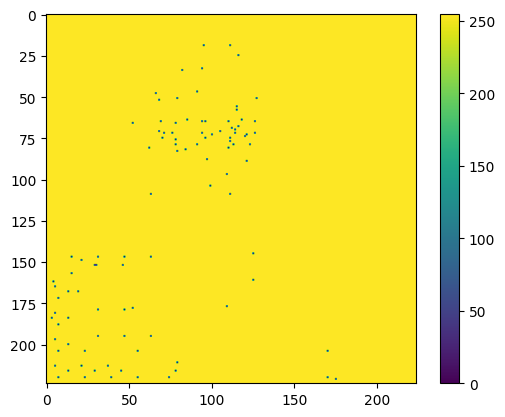

In [19]:
tmp = exchange.exchange_tensor_to_array(block_outputs[0])
b = np.where(tmp < 5, 100, -100)
print(np.where(tmp < 2.5))
exchange.show_heatmap_with_colorbar(np.where(tmp < 3, 255, 0))

50176
<class 'numpy.ndarray'> 50176


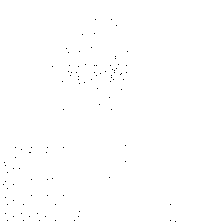

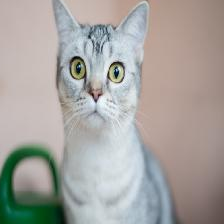

In [25]:
base_img = transform_beta(img)
alpha_img = np.where(tmp < 3, 255, 0)
print(224 * 224)
print(type(alpha_img), alpha_img.size)
alpha_img = Image.fromarray(alpha_img.astype(np.uint8))
alpha_img.show()
base_img.show()

In [ ]:
for i in range(1, 224):
    if 224 % i == 0:
        print(i)

In [ ]:
import scipy.stats
